# MONOGRAFÍA

##1. Librerias

In [ ]:
# Instalación de librería que permite conexión a un repositorio de GitHub
# ==============================================================================
!pip install gitpython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from datetime import datetime
import tabulate

# Acceso a los datos de github
# ==============================================================================
import git
import shutil
import os

# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA # Análisis de Componentes Principales

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Modelos
# ==============================================================================

from scipy.stats import pearsonr
from scipy import stats

#Series de tiempo
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller #estacionariedad
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split

#Evaluación del modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import GridSearchCV


#Creación de modelo
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

##2. Funciones

In [ ]:
# Función para graficar un plot con multiples gráficas del mismo tipo:
#
# df       : dataframe
# cols     : lista de columnas a graficar
# num_cols : número de columnas
# num_rows : número de filas
# tipo     : 'c' = countplot,   'b' = boxplot, 's' = scatterplot
# targetVar: nombre de la variable comparativa de salida. Debe ser numérica y debe estar cotenida en el dataframe.
#            Para countplot no es necesario (None)
# figsize  : tamaño del plot. Valor por defecto (16,8)
#
# *Nota: el número de filas * el número de columnas debe ser mayor al total de elementos de cols
#
# Ejemplos:
#    plot_multiples_graficas (d, catCols, 5, 3, 'c', None, (16,12))
#    plot_multiples_graficas (d, numCols, 5, 3, 's', 'price', (16,12))
#    plot_multiples_graficas (d, ['make'], 1, 1, 'b', 'price', (16,12))
# ==============================================================================


def plot_multiples_graficas(df, cols, num_cols, num_rows, tipo, targetVar, figsize=(16,8)):

    plt.rcParams['figure.figsize'] = figsize

    #num_plots = len(cols)
    #num_cols = math.ceil(np.sqrt(num_plots))
    #num_rows = math.ceil(num_plots/num_cols)

    fig, axs = plt.subplots(num_rows, num_cols)

    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols

        if num_rows == 1:
            if num_cols == 1:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs, dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs)
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs)
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[j])
        else:
            if num_cols == 1:
                if tipo == 'c':
                    sns.countplot(x=d[col], ax=axs[i], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i])
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[i, j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i, j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i, j])

In [ ]:
# Función para convertir una matriz de correlación de pandas en formato tidy:
#
# corr_mat  : Matriz de correlación
#
# Ejemplos:
#    tidy_corr_matrix(corr_mat)
# ==============================================================================
def tidy_corr_matrix(corr_mat):

    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)

    return(corr_mat)

In [ ]:
# Función para calcular el RMSLE (Root Mean Squared Logarithmic Error):
#
# predicted  : Array que contiene los valores predichos por el modelo
# actual     : Array con los valores reales
#
# Ejemplos:
#    rmsle([2,8,7], [3,5,12]])
# ==============================================================================
def RMSLE(predicted, actual):
    # Apply logarithm to predicted and actual values
    predicted_log = np.log1p(predicted)
    actual_log = np.log1p(actual)

    # Calculate the squared differences between predicted and actual logarithmic values
    squared_diff = (predicted_log - actual_log) ** 2

    # Calculate the mean squared difference
    mean_squared_diff = np.mean(squared_diff)

    # Calculate the RMSLE by taking the square root of the mean squared difference
    RMSLE_resultado = np.sqrt(mean_squared_diff)
    return RMSLE_resultado


##3. Cargue de datos

Base de datos

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

In [ ]:
# URL del repositorio
repo_url = 'https://github.com/fdofrancoc/Analitica-UdeA.git'

# Acceso al directorio de ejecución actual
directorio_actual = os.getcwd()

# Se crea una carpeta para clonar los archivos del repositorio a la carpeta local creada
directorio_actual = os.path.join(directorio_actual, 'Monografia')

In [ ]:
# Clonar el repositorio en el directorio especificado
git.Repo.clone_from(repo_url, directorio_actual)

<git.repo.base.Repo '/content/Monografia/.git'>

In [ ]:
# Ruta del archivo fuente en el repositorio clonado
ruta_archivo_fuente = os.path.join(directorio_actual,'transactions.csv')

In [ ]:
df_T = pd.read_csv(ruta_archivo_fuente,parse_dates = ["date"])

##4. Información inicial de las bases de datos

### Base de datos Transaction

In [ ]:
#Información de la bd
df_T.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          83488 non-null  datetime64[ns]
 1   store_nbr     83488 non-null  int64         
 2   transactions  83488 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.9 MB


In [ ]:
df_T.shape

(83488, 3)

In [ ]:
#Primera vista de la bd
df_T.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
#Cantidad de nulos por variable
df_T.isnull().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [ ]:
df_T= df_T.groupby(['date', 'store_nbr']).sum()
df_T = df_T.unstack(level = 1)
df_T['Total_transactions'] = df_T.sum(axis = 1)
df_T = df_T.reset_index()
df_T.head()

date transactions                                          \
store_nbr                       1       2       3       4       5       6   
0         2013-01-01          NaN     NaN     NaN     NaN     NaN     NaN   
1         2013-01-02       2111.0  2358.0  3487.0  1922.0  1903.0  2143.0   
2         2013-01-03       1833.0  2033.0  3026.0  1551.0  1740.0  1795.0   
3         2013-01-04       1863.0  2066.0  3188.0  1596.0  1642.0  1679.0   
4         2013-01-05       1509.0  2062.0  3623.0  1825.0  1643.0  2154.0   

                                   ...                                  \
store_nbr       7       8       9  ...      46      47      48      49   
0             NaN     NaN     NaN  ...     NaN     NaN     NaN     NaN   
1          1874.0  3250.0  2940.0  ...  4886.0  4161.0  3397.0  2346.0   
2          1568.0  2904.0  2396.0  ...  3438.0  3660.0  2887.0  1702.0   
3          1513.0  2962.0  1975.0  ...  3434.0  3915.0  2900.0  2016.0   
4          1599.0  3060.0  2604.0  ...  4935.0  4764.0  4084.0  2562.0   

                                         Total_transactions  
store_nbr      50      51  52  53     54                     
0             NaN     NaN NaN NaN    NaN              770.0  
1          3077.0  1985.0 NaN NaN  998.0            93215.0  
2          2307.0  1644.0 NaN NaN  920.0            78504.0  
3          2698.0  1786.0 NaN NaN  794.0            78494.0  
4          3459.0  2068.0 NaN NaN  949.0            93573.0  

[5 rows x 56 columns]

In [ ]:
#Descripción de transactions
df_T.describe()

transactions                                                      \
store_nbr            1            2            3            4            5   
count      1676.000000  1677.000000  1676.000000  1676.000000  1677.000000   
mean       1523.844272  1920.036374  3201.879475  1502.987470  1400.045915   
std         503.577771   226.496662   435.543650   228.510746   225.305906   
min          10.000000     6.000000  2213.000000   785.000000   721.000000   
25%        1325.750000  1795.000000  2888.750000  1355.000000  1263.000000   
50%        1746.000000  1889.000000  3100.500000  1455.000000  1379.000000   
75%        1832.000000  2006.000000  3457.000000  1613.000000  1496.000000   
max        3023.000000  4060.000000  6085.000000  3589.000000  3468.000000   

                                                                            \
store_nbr            6            7            8            9           10   
count      1676.000000  1675.000000  1676.000000  1676.000000  1675.000000   
mean       1829.293556  1788.652537  2767.285800  2097.948687   986.562985   
std         299.100268   196.749730   311.196509   325.027157   172.061466   
min        1380.000000  1050.000000  1360.000000  1462.000000   615.000000   
25%        1621.000000  1684.500000  2595.000000  1867.000000   866.500000   
50%        1729.000000  1790.000000  2740.500000  2045.000000   962.000000   
75%        2037.000000  1892.000000  2887.250000  2271.000000  1082.000000   
max        4256.000000  3023.000000  5261.000000  4624.000000  2242.000000   

           ...                                                      \
store_nbr  ...           46           47           48           49   
count      ...  1677.000000  1677.000000  1677.000000  1677.000000   
mean       ...  3571.921884  3897.322600  3045.787120  2727.550984   
std        ...   854.048998   716.763182   814.882468   629.057207   
min        ...  2293.000000   765.000000  1833.000000  1376.000000   
25%        ...  2947.000000  3367.000000  2441.000000  2355.000000   
50%        ...  3230.000000  3685.000000  2705.000000  2671.000000   
75%        ...  4243.000000  4413.000000  3689.000000  3097.000000   
max        ...  8001.000000  7727.000000  7044.000000  6600.000000   

                                                                            \
store_nbr           50           51           52           53           54   
count      1677.000000  1677.000000   118.000000  1167.000000  1676.000000   
mean       2614.456768  1713.544425  2333.838983  1011.209940   865.924821   
std         533.064723   266.467374   548.098515   316.108572   169.058412   
min        1769.000000   989.000000  1649.000000    33.000000   179.000000   
25%        2230.000000  1526.000000  1907.750000   777.500000   747.000000   
50%        2448.000000  1685.000000  2154.500000   953.000000   822.000000   
75%        2988.000000  1833.000000  2652.000000  1154.500000   947.250000   
max        5456.000000  3572.000000  4209.000000  2737.000000  1811.000000   

          Total_transactions  
store_nbr                     
count            1682.000000  
mean            84113.522592  
std             12272.597837  
min               770.000000  
25%             76267.250000  
50%             81569.500000  
75%             90773.000000  
max            171169.000000  

[8 rows x 55 columns]

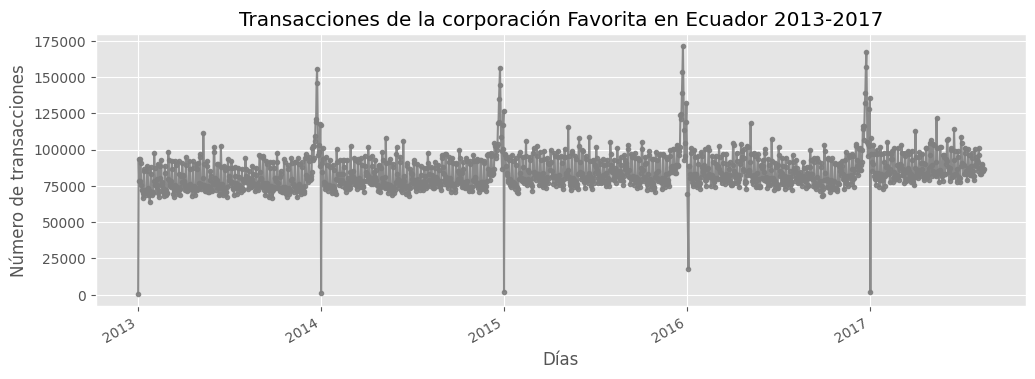

In [ ]:
#Grafica de la serie en bruto
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df_T.groupby('date')['Total_transactions'].sum().\
                plot(y="Total_transactions", marker=".", alpha=0.9, color='grey');

average_week_demand.plot(ax=ax)
_= ax.set(
    title="Transacciones de la corporación Favorita en Ecuador 2013-2017",
    xlabel="Días",
    ylabel="Número de transacciones",
)

In [ ]:
#Guardar imagen de la serie en bruto
fig.savefig("serie_dias.png")

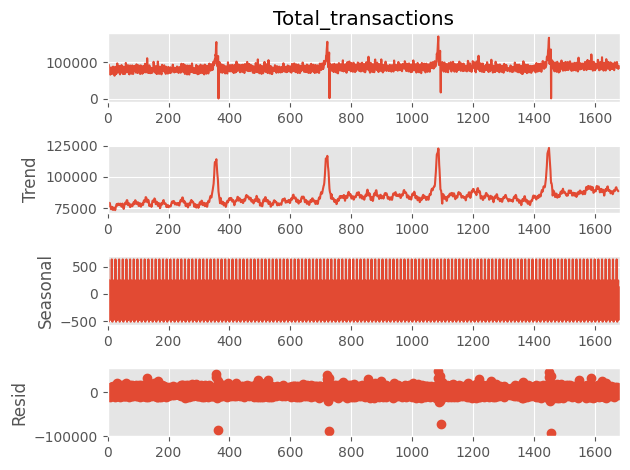

In [ ]:
#descomposición de la serie en bruto tomada por mes
descomposicion_dia = sm.tsa.seasonal_decompose(df_T['Total_transactions'],
                                                  model='additive', period = 12)
fig = descomposicion_dia.plot()

In [ ]:
#Guardar imagen de la descomposicion de la serie en bruto
fig.savefig("descomposicion_serie_dias.png")

### Mes

Se organiza la base de datos para que por meses, se hace esto para ver la serie con mas detalle

In [ ]:
# Agrupar por mes
df_mensual = df_T.groupby(pd.Grouper(key = 'date', freq='M')).sum()

df_mensual.head()

transactions                                                        \
store_nbr             1        2        3        4        5        6        7   
date                                                                            
2013-01-31      47471.0  57588.0  90946.0  45940.0  45355.0  52902.0  47277.0   
2013-02-28      40587.0  51269.0  83135.0  41181.0  42164.0  48108.0  45211.0   
2013-03-31      45299.0  56849.0  95882.0  47712.0  46358.0  56606.0  52587.0   
2013-04-30      46740.0  55188.0  91557.0  44997.0  45004.0  53344.0  51627.0   
2013-05-31      46286.0  56738.0  94211.0  46489.0  46816.0  55612.0  54017.0   

                                       ...                               \
store_nbr         8        9       10  ...        46        47       48   
date                                   ...                                
2013-01-31  82467.0  63137.0  32569.0  ...  104443.0  109668.0  83657.0   
2013-02-28  74560.0  58846.0  30422.0  ...   99084.0  103706.0  81514.0   
2013-03-31  84822.0  68179.0  32940.0  ...  110279.0  116873.0  91996.0   
2013-04-30  81584.0  66724.0  33099.0  ...  104080.0  108571.0  86142.0   
2013-05-31  84017.0  67557.0  33777.0  ...  108774.0  113532.0  90470.0   

                                                         Total_transactions  
store_nbr        49       50       51   52   53       54                     
date                                                                         
2013-01-31  57065.0  75412.0  50762.0  0.0  0.0  25203.0          2289558.0  
2013-02-28  52754.0  72788.0  45917.0  0.0  0.0  24859.0          2169615.0  
2013-03-31  61864.0  82409.0  50731.0  0.0  0.0  28166.0          2458683.0  
2013-04-30  59717.0  77979.0  49800.0  0.0  0.0  26239.0          2344905.0  
2013-05-31  63065.0  82773.0  55239.0  0.0  0.0  27867.0          2467465.0  

[5 rows x 55 columns]

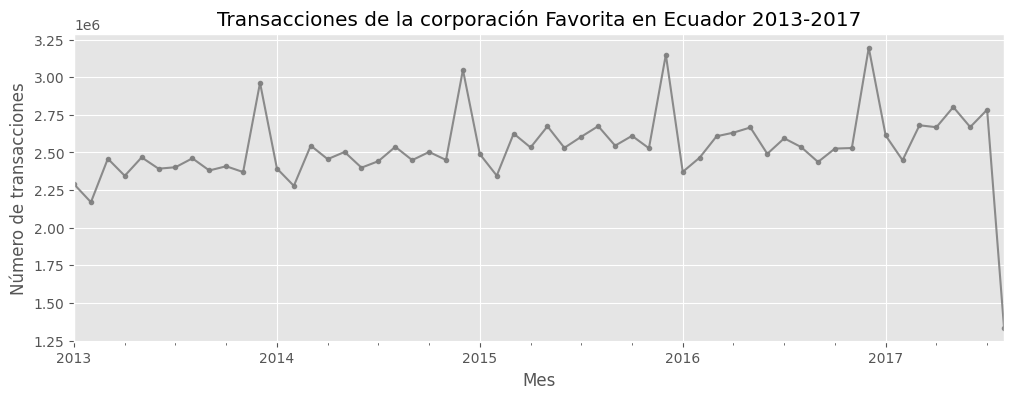

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df_mensual.groupby('date')['Total_transactions'].sum().\
                plot(y="Total_transactions", marker=".", alpha=0.9, color='grey');


average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Transacciones de la corporación Favorita en Ecuador 2013-2017",
    xlabel="Mes",
    ylabel="Número de transacciones",
)

In [ ]:
#Guardar imagen de la serie en bruto mensual
fig.savefig("serie_mes.png")

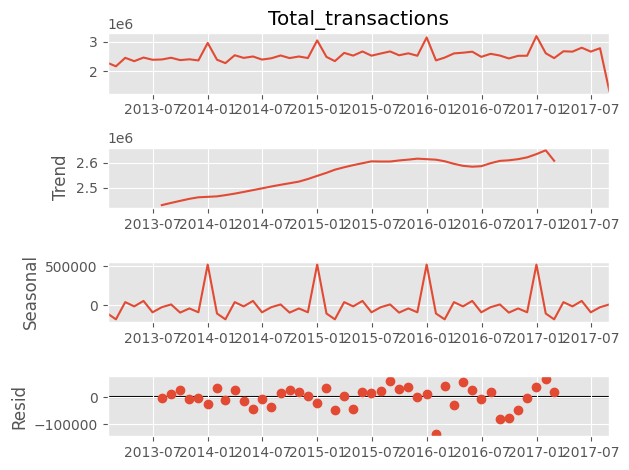

In [ ]:
#descomposición de la serie en bruto tomada por mes
descomposicion_mes = sm.tsa.seasonal_decompose(df_mensual['Total_transactions'],
                                                  model='additive', period = 12)
fig = descomposicion_mes.plot()

In [ ]:
#Guardar imagen descomposicion de la serie en bruto mes
fig.savefig("descomposicion_serie_mes.png")

<Axes: xlabel='date', ylabel='Total_transactions'>

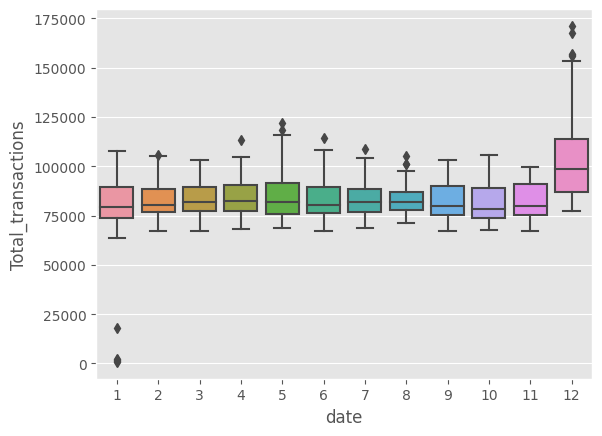

In [ ]:
#box-plot dia semana (0 = lunes y 6 = domingo)
sns.boxplot(data = df_T, x = df_T['date'].dt.month, y = df_T['Total_transactions'])

In [ ]:
#Guardar imagen de la box-plot serie bruto mes
fig.savefig("boxplot_serie_mes.png")

### Semana

In [ ]:
# Agrupar por semana y por cada tienda
df_semana = df_T.groupby([pd.Grouper(key='date', freq='W')]).sum()

df_semana.head()

transactions                                                        \
store_nbr             1        2        3        4        5        6        7   
date                                                                            
2013-01-06       7836.0  10511.0  16914.0   8785.0   8682.0  10084.0   7985.0   
2013-01-13      11093.0  13275.0  20981.0  10584.0  10552.0  12194.0  10482.0   
2013-01-20      10820.0  13129.0  21158.0  10499.0  10317.0  12270.0  11114.0   
2013-01-27      10628.0  13179.0  20757.0  10500.0  10144.0  12105.0  11075.0   
2013-02-03      10808.0  13509.0  21405.0  10720.0  10483.0  12346.0  11541.0   

                                      ...                                      \
store_nbr         8        9      10  ...       46       47       48       49   
date                                  ...                                       
2013-01-06  14924.0  12550.0  5862.0  ...  22094.0  21435.0  17859.0  11421.0   
2013-01-13  19313.0  14764.0  7113.0  ...  23750.0  25493.0  19289.0  13324.0   
2013-01-20  19056.0  14487.0  7389.0  ...  23569.0  25629.0  18852.0  13253.0   
2013-01-27  18603.0  13809.0  7701.0  ...  23463.0  24470.0  18576.0  12852.0   
2013-02-03  19143.0  14792.0  8208.0  ...  24784.0  26317.0  20303.0  13170.0   

                                               Total_transactions  
store_nbr        50       51   52   53      54                     
date                                                               
2013-01-06  14838.0   9417.0  0.0  0.0  4841.0           435020.0  
2013-01-13  17647.0  11890.0  0.0  0.0  5978.0           528431.0  
2013-01-20  17328.0  11880.0  0.0  0.0  5805.0           527766.0  
2013-01-27  17208.0  11387.0  0.0  0.0  5623.0           518361.0  
2013-02-03  17288.0  11808.0  0.0  0.0  5919.0           542655.0  

[5 rows x 55 columns]

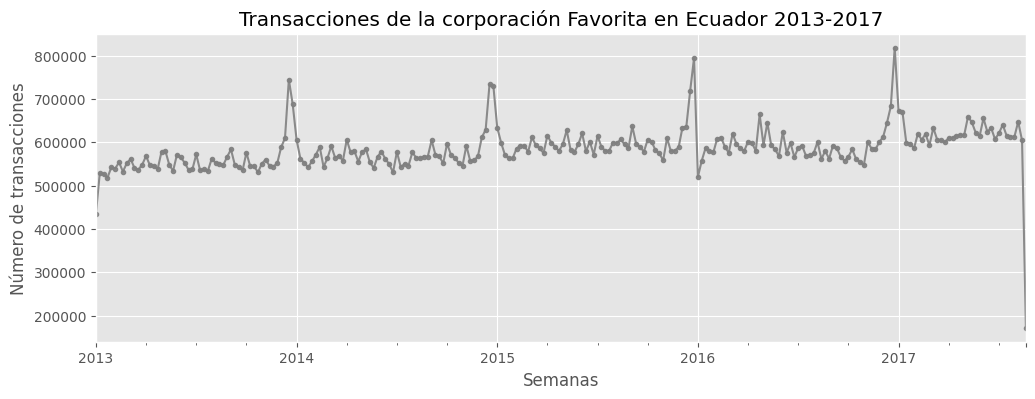

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df_semana.groupby('date')['Total_transactions'].sum().\
                plot(y="Total_transactions", marker=".", alpha=0.9, color='grey');


average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Transacciones de la corporación Favorita en Ecuador 2013-2017",
    xlabel="Semanas",
    ylabel="Número de transacciones",
)

In [ ]:
#Guardar imagen de la serie en bruto semana
fig.savefig("serie_semana.png")

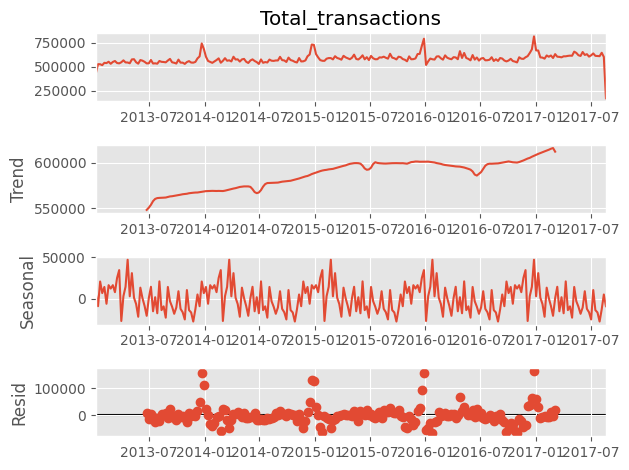

In [ ]:
#descomposición de la serie en bruto tomada por semana
descomposicion_semana = sm.tsa.seasonal_decompose(df_semana['Total_transactions'],
                                                  model='additive', period = 12*4)
fig = descomposicion_semana.plot()

In [ ]:
#Guardar descomposicion serie semana
fig.savefig("descomposicion_serie_semana.png")

<Axes: xlabel='date', ylabel='Total_transactions'>

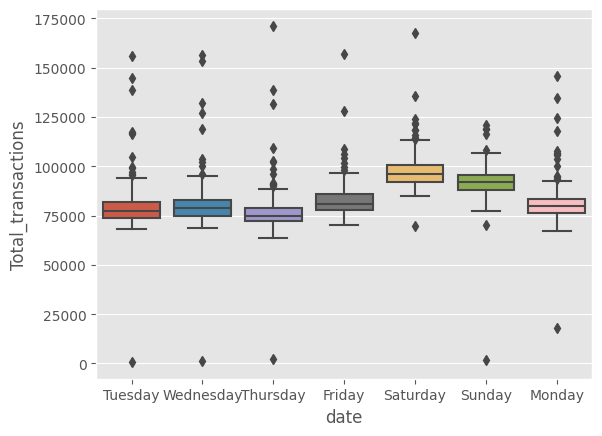

In [ ]:
#box-plot dia semana
sns.boxplot(data = df_T, x = df_T['date'].dt.day_name(), y = df_T['Total_transactions'])

In [ ]:
#Guardar imagen box-plot serie semana
fig.savefig("boxplot_serie_semana.png")

## Modelos

In [ ]:
# División datos de testeo y entrenamiento
Train = df_semana[:'2015']
Test = df_semana['2016':]
Train_size = len(Train)
Test_size = len(Test)

In [ ]:
# Otra forma de dividir los datos 70% datos entrenamiento y 30%datos de testeo
#train_size = int(len(df_semana['Total_transactions'])*0.7)
#test_size = int(len(df_semana['Total_transactions']))-train_size

### Modelo SARIMAX

Creación de una grilla para escoger cuales son los mejores modelos con base a los parametros, al AIC, BIC, MAE, MSE, HQIC

In [ ]:
# Definir los parámetros para buscar en la grilla

p = range(0, 3)  # Rango para el orden AR(p)
d = range(0, 2)  # Rango para el orden de integración d
q = range(0, 3)  # Rango para el orden MA(q)
P = range(0, 2)  # Rango para el orden AR estacional P
D = range(0, 2)  # Rango para el orden de integración estacional D
Q = range(0, 2)  # Rango para el orden MA estacional Q
s = 52  # Período estacionalidad


In [ ]:
criterios = pd.DataFrame()

# Realizar la búsqueda en la grilla manualmente
for p_val in p:
    for d_val in d:
        for q_val in q:
            for P_val in P:
                for D_val in D:
                    for Q_val in Q:
                        try:
                            # Crear el modelo SARIMAX con los parámetros actuales
                            model = SARIMAX(Train['Total_transactions'], order=(p_val, d_val, q_val),
                                            seasonal_order=(P_val, D_val, Q_val, s))

                            # Ajustar el modelo a los datos
                            result = model.fit()

                            # Calcular el puntajes
                            score_AIC = result.aic #Criterio de información de Akaike
                            score_BIC = result.bic #Criterio de información de Bayes
                            #score_MAE = result.mae #Error promedio absoluto del pronostico
                            #score_MSE = result.mse #Error cuadratico medio
                            #score_RMSLE = rmsle()
                            score_HQIC = result.hqic #Criterio de información de Hannan-Quinn

                            criterios = criterios.append(pd.Series([(p_val, d_val, q_val,P_val, D_val, Q_val, s),
                                      score_AIC, score_BIC,score_HQIC],
                                      index = ['Paremetros','AIC','BIC','HQIC']) ,
                                      ignore_index = True)

                        except:
                            continue

criterios
#SE DEMORA 10 MINUTOS

,Paremetros,AIC,BIC,HQIC
0,"(0, 0, 0, 0, 0, 0, 52)",4584.292776,4587.342632,4585.531495
1,"(0, 0, 0, 0, 0, 1, 52)",4618.557813,4624.657525,4621.035252
2,"(0, 0, 0, 0, 1, 0, 52)",2446.376566,2449.020957,2447.447887
3,"(0, 0, 0, 0, 1, 1, 52)",2443.852644,2449.141426,2445.995285
4,"(0, 0, 0, 1, 0, 0, 52)",4011.510168,4017.609880,4013.987606
...,...,...,...,...
138,"(2, 1, 2, 0, 1, 1, 52)",2371.065044,2386.873418,2377.467977
139,"(2, 1, 2, 1, 0, 0, 52)",3640.232612,3658.493163,3647.649637
140,"(2, 1, 2, 1, 0, 1, 52)",3641.560651,3662.864627,3650.213847
141,"(2, 1, 2, 1, 1, 0, 52)",2371.177442,2386.985816,2377.580375


In [ ]:
# Guarda la grilla en un Excel
criterios.to_excel('criterios.xlsx')

In [ ]:
# 10 modelos con el menor AIC
criterios.nsmallest(10,'AIC')

,Paremetros,AIC,BIC,HQIC
106,"(2, 0, 1, 0, 1, 1, 52)",2278.046088,2291.268042,2283.402690
105,"(2, 0, 1, 0, 1, 0, 52)",2280.021618,2290.599182,2284.306900
62,"(1, 0, 1, 1, 1, 1, 52)",2283.831270,2297.053224,2289.187872
113,"(2, 0, 2, 0, 1, 0, 52)",2284.862506,2298.084461,2290.219109
102,"(2, 0, 0, 1, 1, 1, 52)",2285.813838,2299.035793,2291.170440
110,"(2, 0, 1, 1, 1, 1, 52)",2285.937435,2301.803781,2292.365358
65,"(1, 0, 2, 0, 1, 0, 52)",2286.117516,2296.695080,2290.402798
118,"(2, 0, 2, 1, 1, 1, 52)",2287.456057,2305.966793,2294.955300
54,"(1, 0, 0, 1, 1, 1, 52)",2296.854609,2307.432172,2301.139891
34,"(0, 1, 1, 0, 1, 0, 52)",2330.820934,2336.090392,2332.955245


Se seleccionan los modelos que tengan menor AIC,BIC y HQIC, recordenmos que tambien es importante que los modelos sean parsimoniosos, es decir, que no tengan tantos parámetros.

Para este caso, se seleccionan los modelos 106, 105, 65.

#### Modelo 106: SARIMAX (2,0,1)(0,1,1)[52]

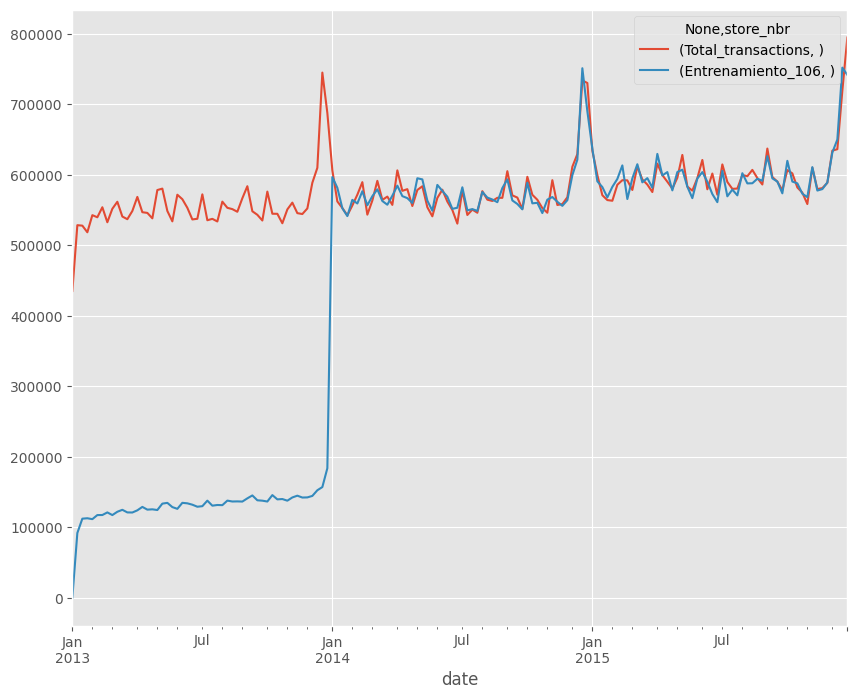

In [ ]:
# Modelo SARIMAX
modelo_106 = sm.tsa.SARIMAX(Train['Total_transactions'], order=(2, 0, 1), seasonal_order=(0, 1, 1, 52))
resultados_106 = modelo_106.fit()
Train['Entrenamiento_106'] = resultados_106.fittedvalues
plot = Train[['Total_transactions', 'Entrenamiento_106']].plot(figsize=(10, 8))

In [ ]:
#Guardar imagen modelo 106
fig.savefig("modelo106.png")

In [ ]:
# Summary
print(resultados_106.summary())

                                     SARIMAX Results                                      
Dep. Variable:                 Total_transactions   No. Observations:                  156
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 52)   Log Likelihood               -1134.023
Date:                            Mon, 19 Jun 2023   AIC                           2278.046
Time:                                    17:45:06   BIC                           2291.268
Sample:                                01-06-2013   HQIC                          2283.403
                                     - 12-27-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2031      0.030     40.275      0.000       1.145       1.262
ar.L2         -0.2082      0.029   

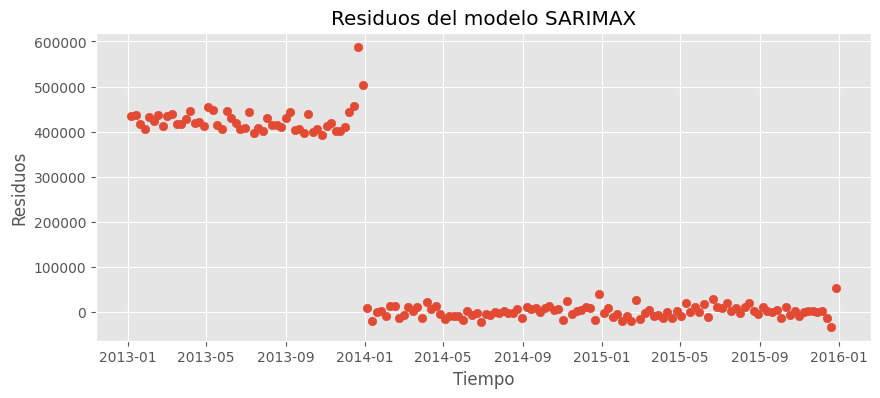

In [ ]:
# Residuales
residuales_106 = resultados_106.resid

# Graficar los residuales
plt.figure(figsize=(10, 4))
plt.scatter(Train.index, residuales_106)
plt.title('Residuos del modelo SARIMAX')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.show()

In [ ]:
#Guardar imagen residuales modelo 106
fig.savefig("residuales_modelo106.png")

In [ ]:
#Resumen de normalidad, p-valor, skewness y curtosis
Normalidad_106 = resultados_106.test_normality('jarquebera')

print("Prueba de normalidad Jarque-Bera:", Normalidad_106[0][0])
print("Prueba de normalidad P-values:", Normalidad_106[0][1])
print("Estadístico de prueba Skewness:", Normalidad_106[0][2])
print("Curtorsis:",Normalidad_106[0][3])

Prueba de normalidad Jarque-Bera: 24.613875595867626
Prueba de normalidad P-values: 4.520274671507458e-06
Estadístico de prueba Skewness: 0.7050905997946892
Curtorsis: 4.9213313409801485


In [ ]:
#Pronosticar resultados
forecast_106 = resultados_106.forecast(steps = Test_size+52)
forecast_106

2016-01-03    663755.546411
2016-01-10    621223.995409
2016-01-17    591634.165616
2016-01-24    584143.071148
2016-01-31    583521.368109
                  ...      
2018-07-22    617236.196590
2018-07-29    636601.651603
2018-08-05    634284.550663
2018-08-12    642627.047812
2018-08-19    631397.801773
Freq: W-SUN, Name: predicted_mean, Length: 138, dtype: float64

<Axes: xlabel='date'>

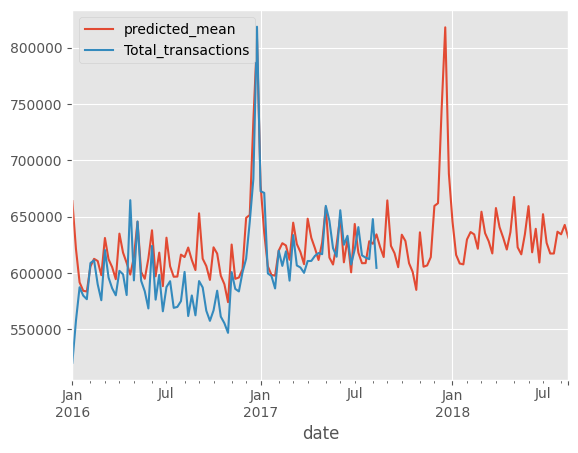

In [ ]:
forecast_106.plot(legend=True)
Test['Total_transactions'][:-1].plot(legend=True)

#### Modelo 105: SARIMAX(2,0,1)(0,1,0)[52]

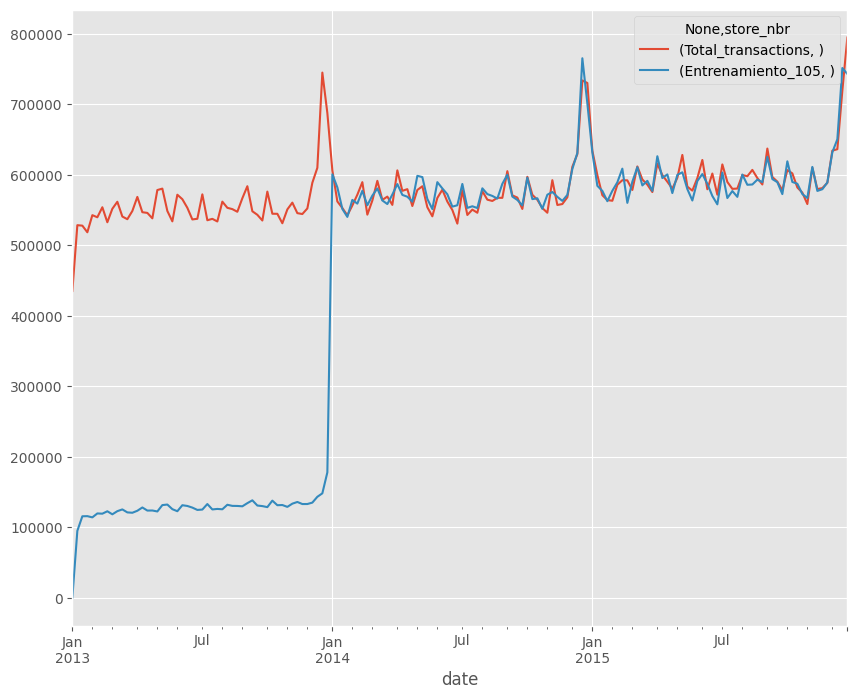

In [ ]:
# Modelo SARIMAX
modelo_105 = sm.tsa.SARIMAX(Train['Total_transactions'], order=(2, 0, 1), seasonal_order=(0, 1, 0, 52))
resultados_105 = modelo_105.fit()
Train['Entrenamiento_105'] = resultados_105.fittedvalues
plot = Train[['Total_transactions', 'Entrenamiento_105']].plot(figsize=(10, 8))

In [ ]:
#Guardar imagen modelo 105
fig.savefig("modelo105.png")

In [ ]:
# Summary
print(resultados_105.summary())

                                      SARIMAX Results                                      
Dep. Variable:                  Total_transactions   No. Observations:                  156
Model:             SARIMAX(2, 0, 1)x(0, 1, [], 52)   Log Likelihood               -1136.011
Date:                             Mon, 19 Jun 2023   AIC                           2280.022
Time:                                     17:45:25   BIC                           2290.599
Sample:                                 01-06-2013   HQIC                          2284.307
                                      - 12-27-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2176      0.037     32.569      0.000       1.144       1.291
ar.L2         -0.2178      

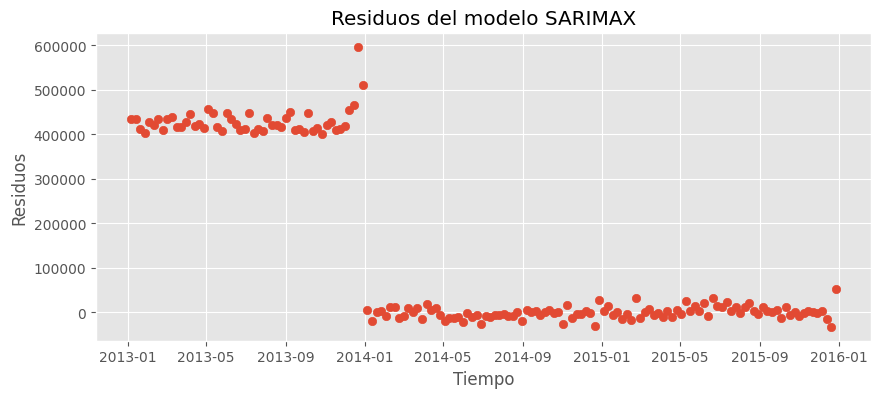

In [ ]:
# Residuales
residuales_105 = resultados_105.resid

# Graficar los residuales
plt.figure(figsize=(10, 4))
plt.scatter(Train.index, residuales_105)
plt.title('Residuos del modelo SARIMAX')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.show()

In [ ]:
#Guardar imagen residuales modelo 105
fig.savefig("residuales_modelo105.png")

In [ ]:
#Resumen de normalidad, p-valor, skewness y curtosis
Normalidad_105 = resultados_105.test_normality('jarquebera')

print("Prueba de normalidad Jarque-Bera:", Normalidad_105[0][0])
print("Prueba de normalidad P-values:", Normalidad_105[0][1])
print("Estadístico de prueba Skewness:", Normalidad_105[0][2])
print("Curtorsis:",Normalidad_105[0][3])

Prueba de normalidad Jarque-Bera: 16.128107187785854
Prueba de normalidad P-values: 0.0003146487584245125
Estadístico de prueba Skewness: 0.5419389304875568
Curtorsis: 4.595957290148159


In [ ]:
#Pronosticar resultados
forecast_105 = resultados_105.forecast(steps = Test_size+52)
forecast_105

2016-01-03    664364.030801
2016-01-10    622182.088539
2016-01-17    591992.998214
2016-01-24    584729.591645
2016-01-31    583698.796884
                  ...      
2018-07-22    641330.154096
2018-07-29    660537.790893
2018-08-05    658810.429452
2018-08-12    667761.069775
2018-08-19    656214.711859
Freq: W-SUN, Name: predicted_mean, Length: 138, dtype: float64

<Axes: xlabel='date'>

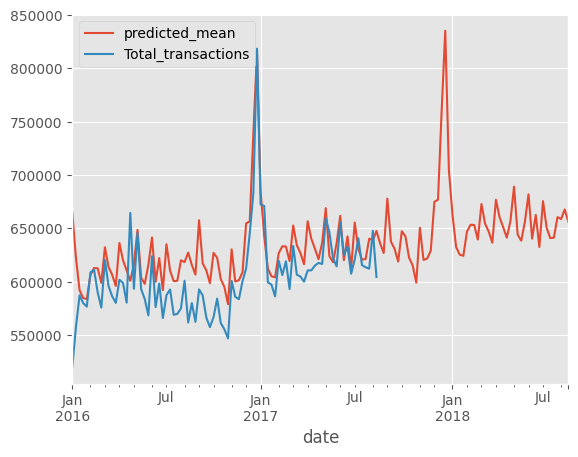

In [ ]:
forecast_105.plot(legend=True)
Test['Total_transactions'][:-1].plot(legend=True)

#### Modelo 65: SARIMAX(1,0,2)(0,1,0)[52]

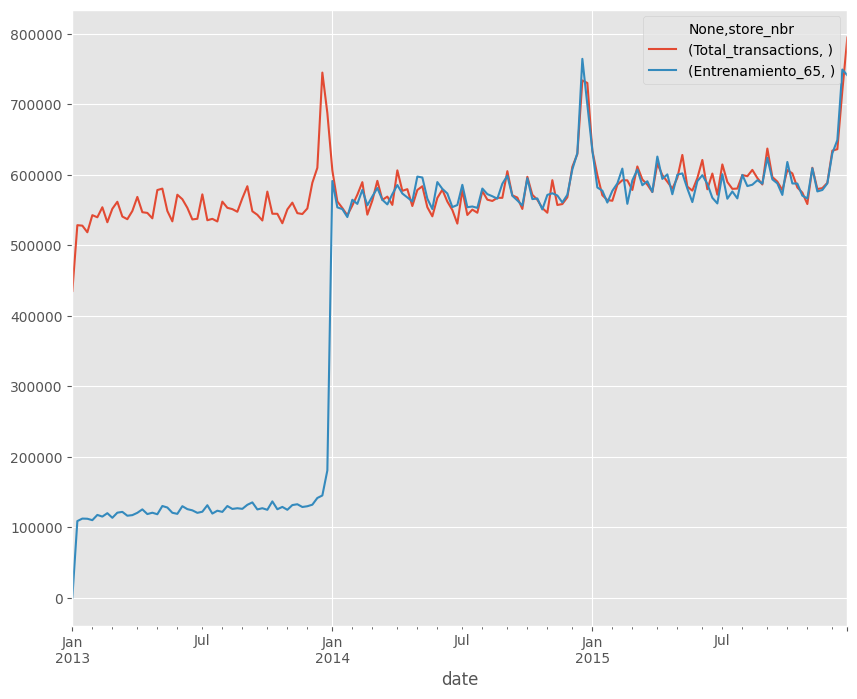

In [ ]:
#Modelo SARIMAX construido manualmente
modelo_65 = sm.tsa.SARIMAX(Train['Total_transactions'], order=(1,0,2), seasonal_order=(0, 1, 0, 52))
resultados_65 = modelo_65.fit()
Train['Entrenamiento_65'] = resultados_65.fittedvalues
plot = Train[['Total_transactions', 'Entrenamiento_65']].plot(figsize=(10, 8))

In [ ]:
#Guardar imagen modelo 65
fig.savefig("modelo65.png")

In [ ]:
# Print the model summary
print(resultados_65.summary())

                                      SARIMAX Results                                      
Dep. Variable:                  Total_transactions   No. Observations:                  156
Model:             SARIMAX(1, 0, 2)x(0, 1, [], 52)   Log Likelihood               -1139.059
Date:                             Mon, 19 Jun 2023   AIC                           2286.118
Time:                                     17:45:37   BIC                           2296.695
Sample:                                 01-06-2013   HQIC                          2290.403
                                      - 12-27-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9988      0.003    372.777      0.000       0.994       1.004
ma.L1         -0.7305      

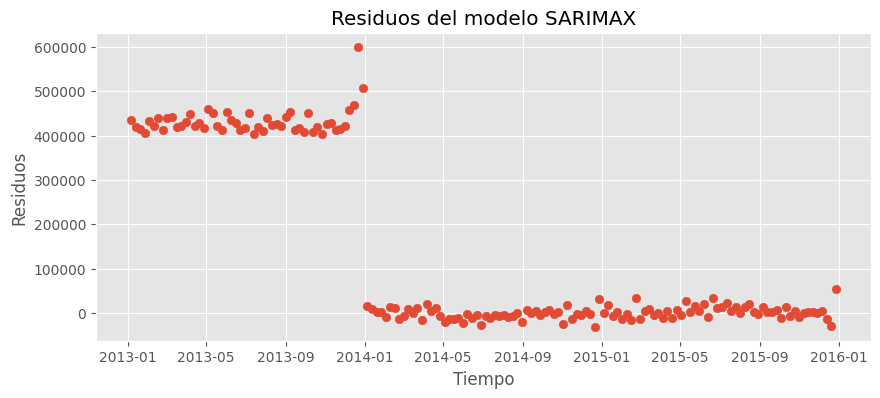

In [ ]:
# Residuales
residuales_65 = resultados_65.resid

# Graficar los residuales
plt.figure(figsize=(10, 4))
plt.scatter(Train.index, residuales_65)
plt.title('Residuos del modelo SARIMAX')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.show()

In [ ]:
#Guardar imagen residuales modelo 65
fig.savefig("residuales_modelo65.png")

In [ ]:
#Resumen de normalidad, p-valor, skewness y curtosis
Normalidad_65 = resultados_65.test_normality('jarquebera')

print("Prueba de normalidad Jarque-Bera:", Normalidad_65[0][0])
print("Prueba de normalidad P-values:", Normalidad_65[0][1])
print("Estadístico de prueba Skewness:", Normalidad_65[0][2])
print("Curtorsis:",Normalidad_65[0][3])

Prueba de normalidad Jarque-Bera: 15.36696337155897
Prueba de normalidad P-values: 0.00046036924416051084
Estadístico de prueba Skewness: 0.5704540169689266
Curtorsis: 4.498182623917949


In [ ]:
#Pronosticar resultados con 52 semanas mas
forecast_65 = resultados_65.forecast(steps = Test_size+52)
forecast_65

2016-01-03    667500.418982
2016-01-10    618431.863915
2016-01-17    589854.053800
2016-01-24    582927.268829
2016-01-31    581955.508973
                  ...      
2018-07-22    632221.632388
2018-07-29    651379.898398
2018-08-05    649603.233274
2018-08-12    658504.636937
2018-08-19    646909.109308
Freq: W-SUN, Name: predicted_mean, Length: 138, dtype: float64

<Axes: xlabel='date'>

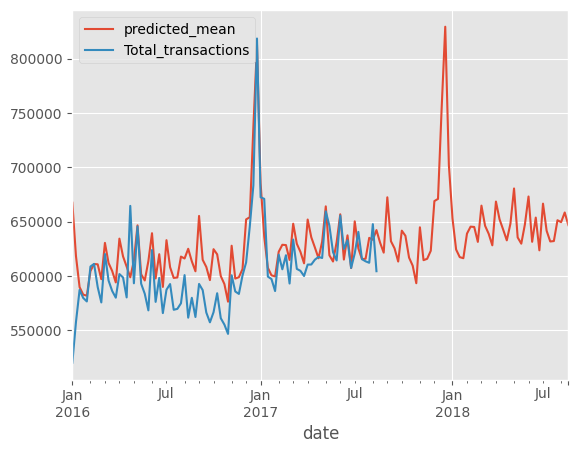

In [ ]:
forecast_65.plot(legend=True)
Test['Total_transactions'][:-1].plot(legend=True)

#### Modelo Franco

In [ ]:
class ModeloFranco:

    def __init__(self,Train_data):
      self.Train_data = Train_data
      self.models = []
    def fit(self):
      models = [
            sm.tsa.SARIMAX(self.Train_data, order=(2,0,1), seasonal_order=(0, 1, 1, 52)),
            sm.tsa.SARIMAX(self.Train_data, order=(2,0,1), seasonal_order=(0, 1, 0, 52)),
            sm.tsa.SARIMAX(self.Train_data, order=(1,0,2), seasonal_order=(0, 1, 0, 52))
        ]
      for model in models:
        self.models.append(model.fit())
    def forecast(self,steps):
      resultados = []
      for model in self.models:
        resultados.append(model.forecast(steps = steps))

      return pd.concat(resultados, axis=1).agg(['mean'], axis=1)

In [ ]:
modelo_franco = ModeloFranco(Train['Total_transactions'])
resultados_MF = modelo_franco.fit()

In [ ]:
forecast_MF = modelo_franco.forecast(steps = Test_size+52)
forecast_MF

,mean
2016-01-03,665206.665398
2016-01-10,620612.649288
2016-01-17,591160.405876
2016-01-24,583933.310541
2016-01-31,583058.557989
...,...
2018-07-22,630262.661025
2018-07-29,649506.446965
2018-08-05,647566.071130
2018-08-12,656297.584841


<Axes: xlabel='date'>

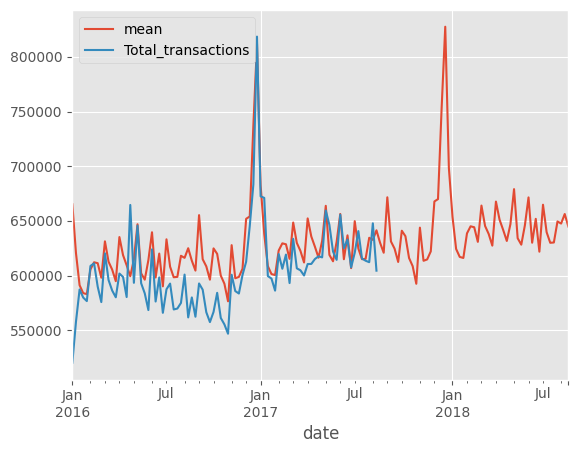

In [ ]:
forecast_MF.plot(legend=True)
Test['Total_transactions'][:-1].plot(legend=True)

## Cross validation

### Cross Validation, modelo 106

In [ ]:
#Se divide el dataset en 5 partes y 52 semanas (estos se escogieron según la inspiración)
tscv = TimeSeriesSplit(n_splits = 6, test_size = 26)

#Lista donde se almacenaran los error de la predicción
rmse = [] #RMSE
rmsle = [] #RMSLE

for Train_index, Test_index in tscv.split(df_semana):
    cv_train, cv_test = df_semana.iloc[Train_index], df_semana.iloc[Test_index]

    modelo_106 = sm.tsa.SARIMAX(Train['Total_transactions'], order=(2, 0, 1), seasonal_order=(0, 1, 1, 52)).fit(disp=False)

    predictions = modelo_106.predict(cv_test.index.values[0], cv_test.index.values[-1])

    true_values = cv_test['Total_transactions'].values
    rmse.append(np.sqrt(mean_squared_error(true_values, predictions)))
    rmsle.append(RMSLE(true_values, predictions))

print("RMSE promedio: {}".format(np.mean(rmse))) #promedio
print("RMLSE promedio: {}".format(np.mean(rmsle))) #promedio
print('RMSE:', rmse) #rmse de cada división
print('RMSLE:',rmsle)
#se demora 5 minutos

RMSE promedio: 35001.47876593725
RMLSE promedio: 0.0752951597336327
RMSE: [14750.630438546517, 12178.736436306433, 33872.31172306675, 29290.668067337705, 29828.903956724036, 90087.62197364206]
RMSLE: [0.02392999138237919, 0.0205084535728363, 0.05592899505604803, 0.04861828291783744, 0.04888723285059235, 0.2538980026221028]


### Cross Validation, modelo 105

In [ ]:
#Se divide el dataset en 5 partes y 52 semanas (estos se escogieron según la inspiración)
tscv = TimeSeriesSplit(n_splits = 6, test_size = 26)

#Lista donde se almacenaran los error de la predicción
rmse = [] #RMSE
rmsle = [] #RMSLE

for Train_index, Test_index in tscv.split(df_semana):
    cv_train, cv_test = df_semana.iloc[Train_index], df_semana.iloc[Test_index]

    modelo_105 = sm.tsa.SARIMAX(Train['Total_transactions'], order=(2, 0, 1), seasonal_order=(0, 1, 0, 52)).fit(disp=False)

    predictions = modelo_105.predict(cv_test.index.values[0], cv_test.index.values[-1])

    true_values = cv_test['Total_transactions'].values
    rmse.append(np.sqrt(mean_squared_error(true_values, predictions)))
    rmsle.append(RMSLE(true_values, predictions))

print("RMSLE promedio: {}".format(np.mean(rmsle))) #promedio
print("RMSE promedio: {}".format(np.mean(rmse))) #promedio
print('RMSE:', rmse) #rmse de cada división
print('RMSLE:',rmsle)

RMSLE promedio: 0.07784855473475241
RMSE promedio: 36620.059074605546
RMSE: [14177.03343842105, 13028.519299332964, 33994.38334638845, 31603.076535630942, 33479.700174757694, 93437.64165310218]
RMSLE: [0.022927170980162146, 0.02201452005486724, 0.056177159408898794, 0.052426387103358445, 0.05486109503357426, 0.2586849958276536]


### Cross Validation, modelo 65

In [ ]:
#Se divide el dataset en 5 partes y 52 semanas (estos se escogieron según la inspiración)
tscv = TimeSeriesSplit(n_splits = 6, test_size = 26)

#Lista donde se almacenaran los error de la predicción
rmse = [] #RMSE
rmsle = [] #RMSLE

for Train_index, Test_index in tscv.split(df_semana):
    cv_train, cv_test = df_semana.iloc[Train_index], df_semana.iloc[Test_index]

    modelo_65 = sm.tsa.SARIMAX(cv_train['Total_transactions'], order=(1,0,2), seasonal_order=(0, 1, 0, 52)).fit(disp=False)

    predictions = modelo_65.predict(cv_test.index.values[0], cv_test.index.values[-1])

    true_values = cv_test['Total_transactions'].values
    rmse.append(np.sqrt(mean_squared_error(true_values, predictions)))
    rmsle.append(RMSLE(true_values, predictions))

print("RMSLE promedio: {}".format(np.mean(rmsle))) #promedio
print("RMSE promedio: {}".format(np.mean(rmse))) #promedio
print('RMSE:', rmse) #rmse de cada división
print('RMSLE:',rmsle)

RMSLE promedio: 0.07979939949612352
RMSE promedio: 37765.827860268
RMSE: [19835.69740949338, 17388.453332840516, 31544.433284952578, 28714.840078500867, 42549.491178969416, 86562.05187685127]
RMSLE: [0.03344559969340964, 0.02966713804085512, 0.05247792403602338, 0.047653656303203284, 0.07034674635566092, 0.24520533254758878]


In [ ]:
#Se divide el dataset en 5 partes y 52 semanas (estos se escogieron según la inspiración)
tscv = TimeSeriesSplit(n_splits = 6, test_size = 26)

#Lista donde se almacenaran los error de la predicción
rmse = [] #RMSE
rmsle = [] #RMSLE

for Train_index, Test_index in tscv.split(df_semana):
    cv_train, cv_test = df_semana.iloc[Train_index], df_semana.iloc[Test_index]

    modelo_franco = ModeloFranco(Train['Total_transactions'])
    resultados_MF = modelo_franco.fit()
    predictions = modelo_franco.forecast(steps = len(cv_test.index))

    true_values = cv_test['Total_transactions'].values
    rmse.append(np.sqrt(mean_squared_error(true_values, predictions)))
    rmsle.append(RMSLE(true_values, predictions.values))

print("RMSE promedio: {}".format(np.mean(rmse))) #promedio
print("RMLSE promedio: {}".format(np.mean(rmsle))) #promedio
print('RMSE:', rmse) #rmse de cada división
print('RMSLE:',rmsle)

#sedemoro 5 minutos

RMSE promedio: 53795.927339083835
RMLSE promedio: 0.10440690968011009
RMSE: [53813.418711981445, 27586.009546633497, 58046.193048480956, 38441.35539239282, 58150.53141107271, 86738.05592394162]
RMSLE: [0.08737955536750579, 0.04917697387373718, 0.08705317264594094, 0.06000613705316028, 0.090306071539975, 0.25251954760034134]
